# Import

In [1]:
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from load_data.prepared_custom_ds import CustomDataset
from utilities.config_load import load_config
from utilities.RecallAndPrecision import Metrics
from utilities.weighted_cross_entropy import weighted_cross_entropy

import time
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

from sklearn.model_selection import train_test_split
from utilities.pkl import get_pkl
import numpy as np

In [2]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load data and config

In [4]:
CONFIG_PATH = "configs/"
config = load_config(CONFIG_PATH, "config.yaml")

In [5]:
img_ids = get_pkl(config['dataset']['index_path'])

In [6]:
mask_ids = [name + ".npy" for name in img_ids]

In [7]:
masks = list()
for id in tqdm(mask_ids):
    masks.append(np.load(config['dataset']['mask_path'] + "/" + id))

100%|████████████████████████████████████████████████████████████████████████████| 66922/66922 [11:31<00:00, 96.83it/s]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(img_ids, 
                                                    masks, 
                                                    test_size=0.05,
                                                    random_state=42)

# Model

In [9]:
def ConvBlock(first_chanels, second_chanels, kernel_size, dropout_rate):
    return nn.Sequential(
        nn.BatchNorm2d(first_chanels),
        nn.Conv2d(first_chanels, second_chanels, kernel_size, padding='same'),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_rate),
        nn.BatchNorm2d(second_chanels),
        nn.Conv2d(second_chanels, second_chanels, kernel_size, padding='same'),
        nn.ReLU(inplace=True)
    )

In [10]:
class Unet_Encoder(nn.Module):
    def __init__(self, kernel_size, dropout_rate, nkernels):
        super(Unet_Encoder, self).__init__()
        self.kernel_size = kernel_size
        self.dropout_rate = dropout_rate
        self.nkernels = nkernels
        self.conv1 = ConvBlock(3, nkernels, self.kernel_size, self.dropout_rate)
        self.conv2 = ConvBlock(nkernels, nkernels*2, self.kernel_size, self.dropout_rate)
        self.conv3 = ConvBlock(nkernels*2, nkernels*4, self.kernel_size, self.dropout_rate)
        self.conv4 = ConvBlock(nkernels*4, nkernels*8, self.kernel_size, self.dropout_rate)
        self.maxpool_list = nn.ModuleList([nn.MaxPool2d(kernel_size=2) for _ in range(4)])
        self.conv_list = nn.ModuleList([self.conv1, self.conv2, self.conv3, self.conv4])
        self.init_weights()

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.01)

    def forward(self, input):
        list_skips = list()
        for i in range(4):
            skip = self.conv_list[i](input)
            input = self.maxpool_list[i](skip)
            list_skips.append(skip)
        return input, list_skips

In [11]:
class Unet_Decoder(nn.Module):
    def __init__(self, kernel_size, dropout_rate, nkernels):
        super(Unet_Decoder, self).__init__()
        self.kernel_size = kernel_size
        self.dropout_rate = dropout_rate
        self.nkernels = nkernels
        self.conv5 = ConvBlock(nkernels*8, nkernels*16, self.kernel_size, self.dropout_rate)
        self.conv6 = ConvBlock(nkernels*16, nkernels*8, self.kernel_size, self.dropout_rate)
        self.conv7 = ConvBlock(nkernels*8, nkernels*4, self.kernel_size, self.dropout_rate)
        self.conv8 = ConvBlock(nkernels*4, nkernels*2, self.kernel_size, self.dropout_rate)
        self.conv_list = nn.ModuleList([self.conv5, self.conv6, self.conv7, self.conv8])
        self.convt_list = nn.ModuleList([nn.ConvTranspose2d(nkernels*(2**(4-i)), nkernels*((2**(4-i))//2), kernel_size=(2, 2), stride=(2, 2)) 
                                           for i in range(4)])
        self.init_weights()

    
    def init_weights(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.01)

    
    def forward(self, input, list_skips):
        for i in range(4):
            if i==0:
                out = self.conv_list[i](input)
                out = self.convt_list[i](out)
            else:
                out = self.conv_list[i](torch.cat((out, list_skips[4-i]), 1)) # channel
                out = self.convt_list[i](out)
        return out

In [12]:
class Model_Unet(nn.Module):
    def __init__(self, kernel_size, dropout_rate, nkernels, output_chanels):
        super(Model_Unet, self).__init__()
        self.output_chanels = output_chanels
        self.kernel_size = kernel_size
        self.dropout_rate = dropout_rate
        self.nkernels = nkernels
        self.enc_layer = Unet_Encoder(self.kernel_size, self.dropout_rate, self.nkernels)
        self.dec_layer = Unet_Decoder(self.kernel_size, self.dropout_rate, self.nkernels)
        self.conv9 = ConvBlock(self.nkernels*2, self.nkernels, self.kernel_size, self.dropout_rate)
        self.conv10 = nn.Conv2d(self.nkernels, self.output_chanels, (1, 1), padding='same')
        self.relu = nn.ReLU()
        self.activation = nn.Sigmoid()
        self.init_weights()
        

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.01)

    
    def forward(self, input):
        out, list_skips = self.enc_layer(input)
        out = self.dec_layer(out, list_skips)
        out = self.conv9(torch.cat((out, list_skips[0]), 1)) # channel concat
        out = self.relu(out)
        out = self.conv10(out)
        #out = self.activation(out)
        return out

# Train function

In [13]:
def train_step(model, loss_fn, opt, loader):
    loss_per_batches = 0
    elapsed = 0
    start_epoch2 = time.time()
    for i, data in tqdm(enumerate(loader), total=66922//72):

        start_epoch = time.time()
        features, labels = data
        features, labels = features.to(device), labels.to(device)
        opt.zero_grad()
        
        y_pred = model(features)
        loss, _ = loss_fn(torch.flatten(y_pred), torch.flatten(labels))
        loss.backward()
        
        opt.step()
        
        loss_per_batches += loss
        end_epoch = time.time()
        elapsed += (end_epoch - start_epoch)

    print("train = " + str(elapsed))
    print("train + load = " + str(time.time() - start_epoch2))
    return loss_per_batches/(i+1)

In [14]:
def train(model, loss_fn, opt, train_loader, val_loader, save_treshold=10, epochs=50, model_name='model_name'):
        
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('runs/' + model_name + '_{}'.format(timestamp))
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=3, verbose=True)
    
    for epoch in range(epochs):
        start_epoch = time.time()
        metrics_valid = Metrics()
        print('EPOCH {}:'.format(epoch + 1))
        
        model.train()
        avg_loss = train_step(model, loss_fn, opt, train_loader)
        model.eval()

        vloss = 0
        counter = 0
        with torch.inference_mode():
            for i, vdata in enumerate(val_loader):
                vfeatures, vlabels = vdata
                vfeatures, vlabels = vfeatures.to(device), vlabels.to(device)

                y_pred = model(vfeatures)
                bloss, y_pred = loss_fn(torch.flatten(y_pred), torch.flatten(vlabels))
                vloss += bloss
                metrics_valid.batch_step(torch.flatten(vlabels), y_pred)
                counter = i

        avg_vloss = vloss / (counter + 1)
        
        scheduler.step(avg_loss)

        valrecall, valprecision, valmetr = metrics_valid.get_metrics()
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
        print('Recall valid {}'.format(valrecall))
        print('Precision valid {}'.format(valprecision))
        print('Val TP->{} | FN ->{}| FP->{} | TN->{}'.format(*valmetr))
        
        writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch + 1)
        writer.add_scalars('Validation Metrics',
                    { 'Validation Recall' : valrecall, 'Training Precision' : valprecision
                    }, epoch + 1)
        
        if (epoch + 1) % save_treshold == 0:
            model_path = config['model']['svs_path'] + model_name +'_{}_{}'.format(timestamp, (epoch + 1))
            torch.save(model.state_dict(), model_path)
        end_epoch = time.time()
        elapsed = end_epoch - start_epoch
        print("Time per epoch {}s".format(elapsed))

# Creating dataloader and model objects

In [15]:
dataset = CustomDataset(config, X_train, y_train)
vdataset = CustomDataset(config, X_test, y_test)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=72, num_workers=0, shuffle=True)
vdataloader = torch.utils.data.DataLoader(vdataset, batch_size=72, num_workers=0, shuffle=True)

In [16]:
fp16_model = Model_Unet(kernel_size=3, dropout_rate=0.15, nkernels=4, output_chanels=1) #.half() 
pos_weight = torch.tensor([config['train']['positive_weight']], dtype=torch.float32).to(device)
#loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
loss_fn = weighted_cross_entropy
optimizer = torch.optim.Adam(fp16_model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
fp16_model.to(device)
pass

In [17]:
summary(fp16_model)
pass

Layer (type:depth-idx)                   Param #
├─Unet_Encoder: 1-1                      --
|    └─Sequential: 2-1                   --
|    |    └─BatchNorm2d: 3-1             6
|    |    └─Conv2d: 3-2                  112
|    |    └─ReLU: 3-3                    --
|    |    └─Dropout: 3-4                 --
|    |    └─BatchNorm2d: 3-5             8
|    |    └─Conv2d: 3-6                  148
|    |    └─ReLU: 3-7                    --
|    └─Sequential: 2-2                   --
|    |    └─BatchNorm2d: 3-8             8
|    |    └─Conv2d: 3-9                  296
|    |    └─ReLU: 3-10                   --
|    |    └─Dropout: 3-11                --
|    |    └─BatchNorm2d: 3-12            16
|    |    └─Conv2d: 3-13                 584
|    |    └─ReLU: 3-14                   --
|    └─Sequential: 2-3                   --
|    |    └─BatchNorm2d: 3-15            16
|    |    └─Conv2d: 3-16                 1,168
|    |    └─ReLU: 3-17                   --
|    |    └─Dropout: 3-

# Training

In [18]:
train(fp16_model, loss_fn, optimizer, dataloader, vdataloader, 2, epochs=30, model_name='test_try')

EPOCH 1:


 95%|████████████████████████████████████████████████████████████████████████████    | 883/929 [06:02<00:18,  2.44it/s]


train = 220.4647877216339
train + load = 362.50537061691284
LOSS train 0.011333259753882885 valid 0.008412379771471024
Recall valid 0.9674964547157288
Precision valid 0.2195352017879486
Val TP->5505226.0 | FN ->184951.0| FP->19571508.0 | TN->194087344.0
Time per epoch 378.93601417541504s
EPOCH 2:


 95%|████████████████████████████████████████████████████████████████████████████    | 883/929 [05:57<00:18,  2.47it/s]


train = 243.62493109703064
train + load = 357.684446811676
LOSS train 0.006946966517716646 valid 0.006212303880602121
Recall valid 0.9759557843208313
Precision valid 0.28358975052833557
Val TP->5553361.0 | FN ->136816.0| FP->14029016.0 | TN->199629808.0
Time per epoch 373.51657605171204s
EPOCH 3:


 95%|████████████████████████████████████████████████████████████████████████████    | 883/929 [06:00<00:18,  2.45it/s]


train = 239.3788778781891
train + load = 360.647775888443
LOSS train 0.005794237367808819 valid 0.005440053530037403
Recall valid 0.9805408716201782
Precision valid 0.3122037947177887
Val TP->5579451.0 | FN ->110726.0| FP->12291731.0 | TN->201367088.0
Time per epoch 376.94013381004333s
EPOCH 4:


 95%|████████████████████████████████████████████████████████████████████████████    | 883/929 [05:59<00:18,  2.46it/s]


train = 226.599182844162
train + load = 359.2414367198944
LOSS train 0.0052870805375278 valid 0.0052116988226771355
Recall valid 0.9763959646224976
Precision valid 0.3459087014198303
Val TP->5555866.0 | FN ->134311.0| FP->10505789.0 | TN->203153024.0
Time per epoch 375.8544042110443s
EPOCH 5:


 95%|████████████████████████████████████████████████████████████████████████████    | 883/929 [05:59<00:18,  2.45it/s]


train = 240.57764530181885
train + load = 359.75228214263916
LOSS train 0.004803462419658899 valid 0.00438575679436326
Recall valid 0.9824840426445007
Precision valid 0.3733140230178833
Val TP->5590508.0 | FN ->99669.0| FP->9384841.0 | TN->204273984.0
Time per epoch 375.04535818099976s
EPOCH 6:


 95%|████████████████████████████████████████████████████████████████████████████    | 883/929 [05:58<00:18,  2.46it/s]


train = 257.9939410686493
train + load = 358.4560317993164
LOSS train 0.00452083395794034 valid 0.0041054715402424335
Recall valid 0.9851229786872864
Precision valid 0.3932991921901703
Val TP->5605524.0 | FN ->84653.0| FP->8647045.0 | TN->205011808.0
Time per epoch 373.3838531970978s
EPOCH 7:


 95%|████████████████████████████████████████████████████████████████████████████    | 883/929 [05:58<00:18,  2.46it/s]


train = 262.97555661201477
train + load = 358.575501203537
LOSS train 0.004300268832594156 valid 0.004226919263601303
Recall valid 0.984879195690155
Precision valid 0.37926697731018066
Val TP->5604137.0 | FN ->86040.0| FP->9172095.0 | TN->204486720.0
Time per epoch 373.56399750709534s
EPOCH 8:


 95%|████████████████████████████████████████████████████████████████████████████    | 883/929 [05:57<00:18,  2.47it/s]


train = 262.1802444458008
train + load = 357.582612991333
LOSS train 0.004081544000655413 valid 0.004107796121388674
Recall valid 0.9849419593811035
Precision valid 0.389611154794693
Val TP->5604494.0 | FN ->85683.0| FP->8780346.0 | TN->204878464.0
Time per epoch 371.7311384677887s
EPOCH 9:


 11%|█████████                                                                       | 105/929 [00:42<05:34,  2.46it/s]


KeyboardInterrupt: 

# Test

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [26]:
fp16_model.load_state_dict(torch.load('model_svs/test_try_20240707_194916_8'))
fp16_model.eval()
pass

In [32]:
test_imgs = list()
for img_id in X_test[0:10]:
    image = cv2.imread(config['dataset']['reshaped_img_path'] + "/" + img_id)                                    
    tens_img = torch.tensor(np.transpose(image, (2, 0, 1)), dtype=torch.float32)  
    norm_image = tens_img / 127.5 - 1
    print(norm_image.size())
    test_imgs.append(norm_image)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


In [35]:
batch_tensor = torch.stack(test_imgs).to(device)

In [36]:
with torch.no_grad():  # Disable gradient calculation for inference
    first_ten_img = fp16_model(batch_tensor)

In [42]:
first_ten_img = first_ten_img.numpy(force=True)

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

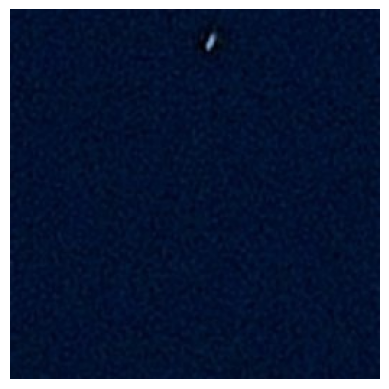

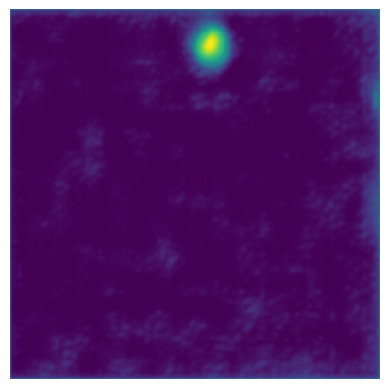

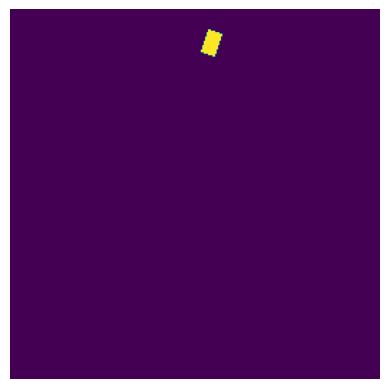

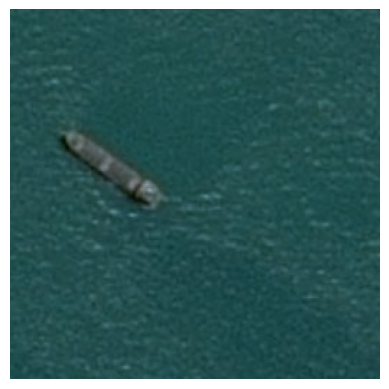

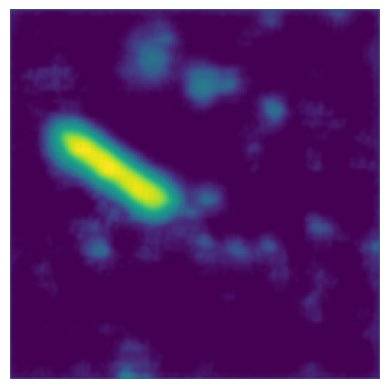

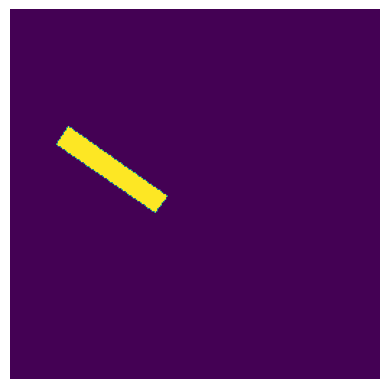

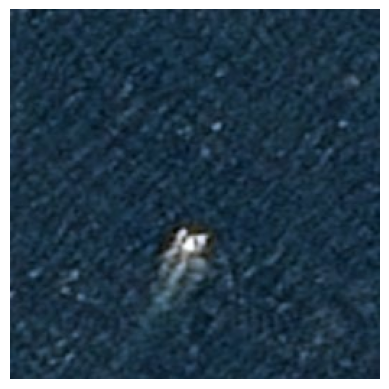

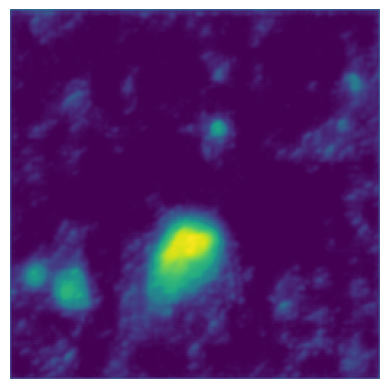

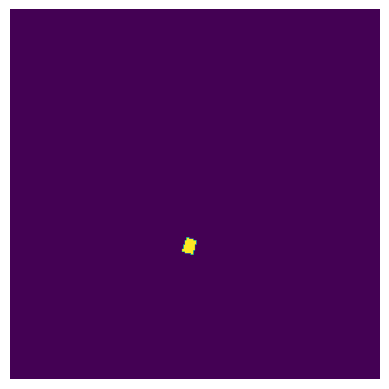

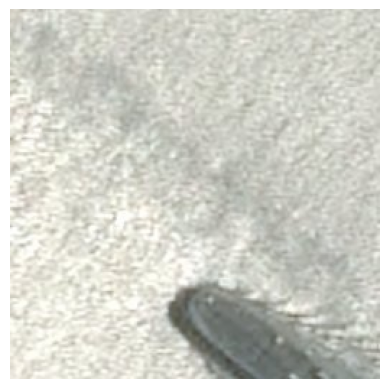

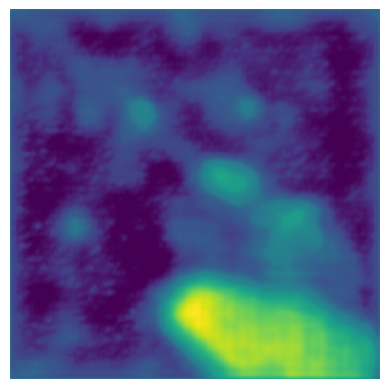

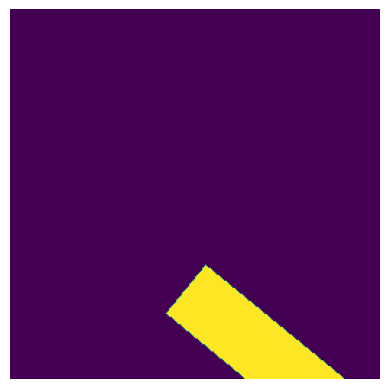

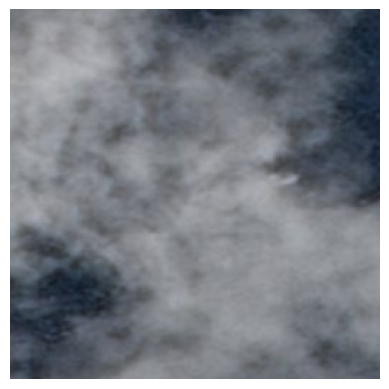

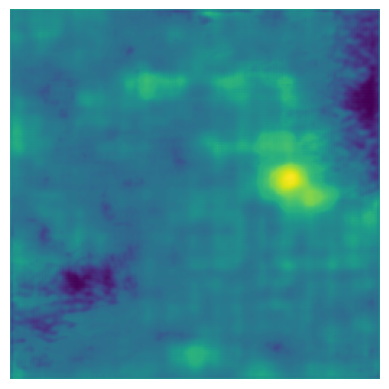

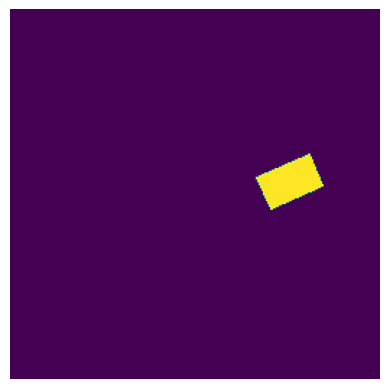

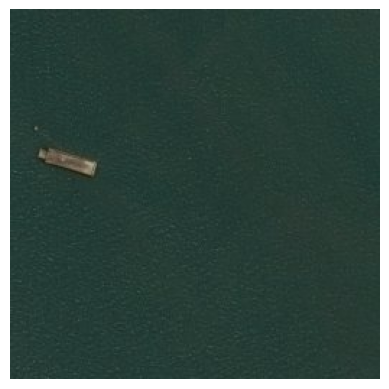

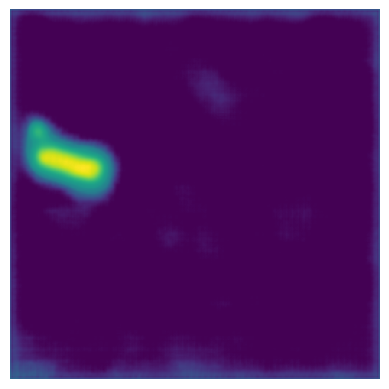

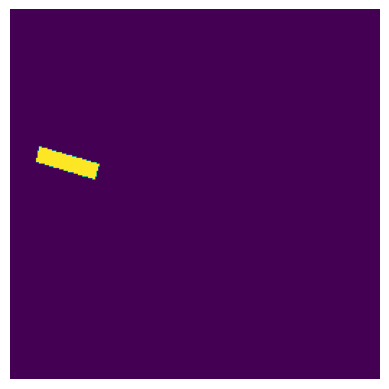

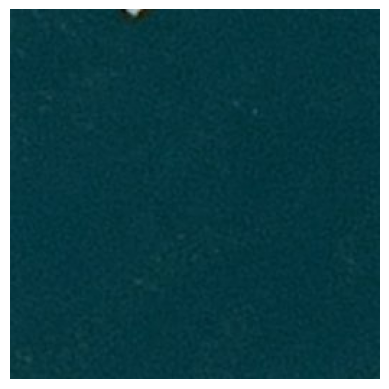

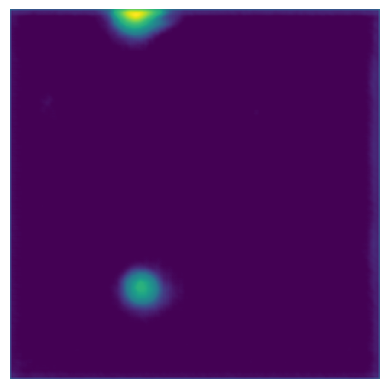

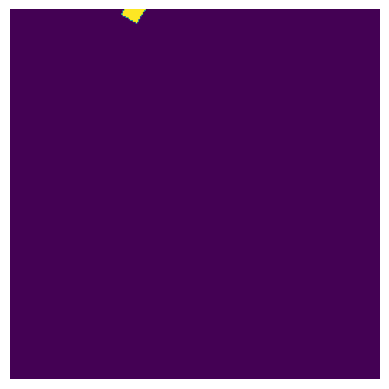

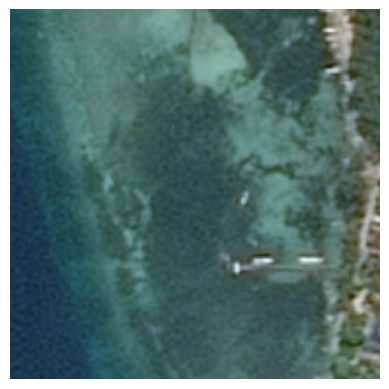

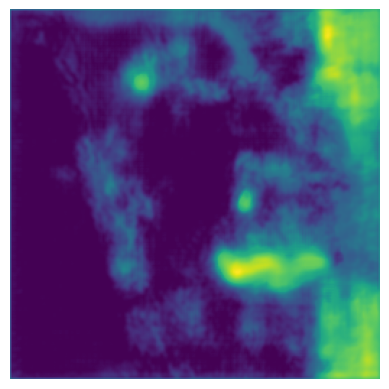

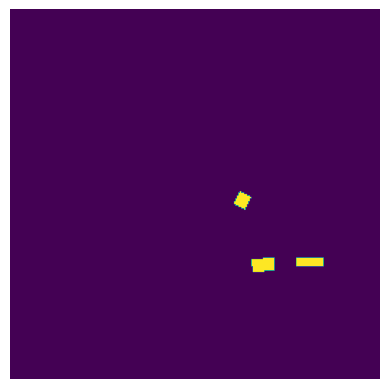

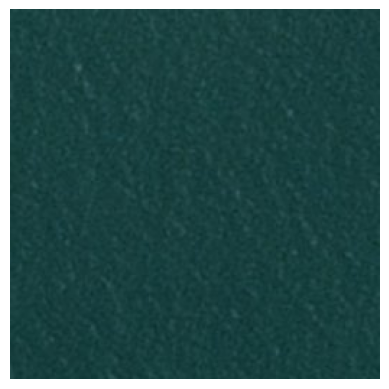

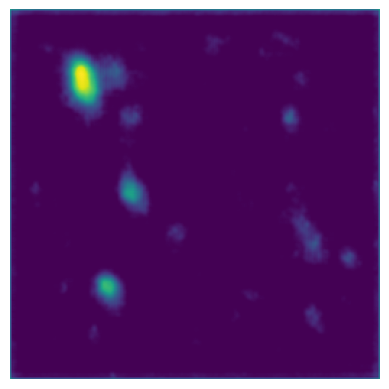

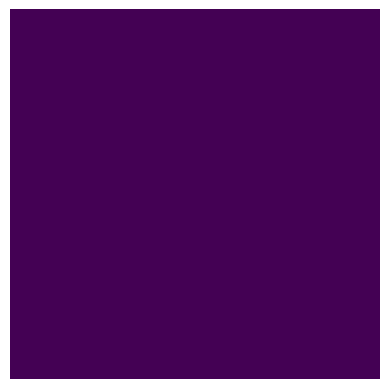

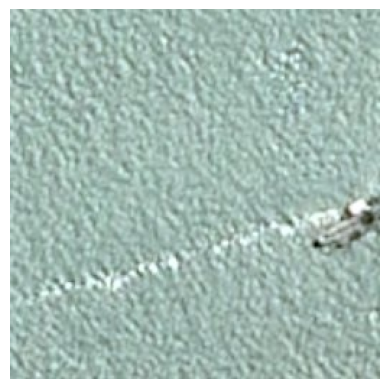

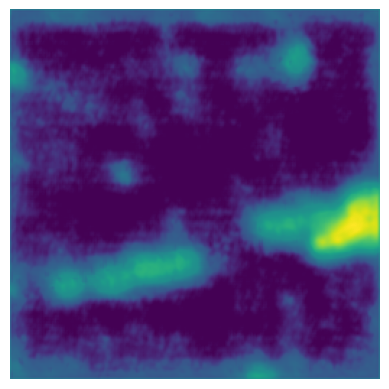

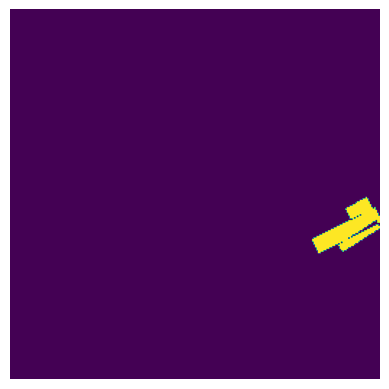

In [47]:
for orign, img, mask in zip(X_test[0:10], first_ten_img, y_test[0:10]):
    image = cv2.imread(config['dataset']['reshaped_img_path'] + "/" + orign)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    plt.imshow(mask)
    plt.axis('off')
    plt.show()